This notebook illustrates taking successive cuts on the data and plotting the resulting hit distributions after the cuts. The cuts are made along the x-axis at stations 1, 2, and 4 in the detector pairs H1B/T, H2B/T, and H4B/T respectively. The H1XY plots show the hits/event after the station 1 cut is performed, the H2XY plots show the hits/event after both station 1 and station 2 cuts are performed, and the H4XY plots show the hits/event after all four cuts are performed. 

Normalization is achieved by taking the total number of hits in all events meeting the given criteria and dividing by the number of valid events remaining after the cuts were imposed. To ensure proper readings, the weights are divided by 2 on all station 4 plots, since detectors in these stations count two hits for every one real hit. 

# Imports

In [6]:
import uproot4   # concatenate bkg data
import uproot
import awkward1 as ak
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.ROOT)

# Files

In [7]:
root = uproot4.concatenate("../2017Data/combined_data/track_*.root:save/rawEvent",["fTriggerBits","fAllHits.pos","fAllHits.driftDistance","fAllHits.detectorID"],library="ak",how="zip")

In [8]:
# Names
Brem003 = "../electrons/sim_eval_Brem_0.033428_z500_600_eps_-5.2.root"
Brem047 = "../electrons/sim_eval_Brem_0.470915_z500_600_eps_-6.root"
Eta001 = "../electrons/sim_eval_Eta_0.019564_z500_600_eps_-5.2.root"
Eta054 = "../electrons/sim_eval_Eta_0.540000_z500_600_eps_-6.root"

# Get background data

In [177]:
def get_BackgroundData(root):
    bg_events = ak.zip({"Hits":ak.zip({
                                        "detectorID": root.fAllHits["detectorID"],
                                        "pos": root.fAllHits["pos"]
                                      })
                       }, depth_limit=1)
    return bg_events

def H1BT(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 31) & (arr.detectorID <= 32)
    else:
        mask = (arr.detID >= 31) & (arr.detID <= 32)
    return mask

def H1LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 33) & (arr.detectorID <= 34)
    else:
        mask = (arr.detID >= 33) & (arr.detID <= 34)
    return mask

def H2BT(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 37) & (arr.detectorID <= 38)
    else:
        mask = (arr.detID >= 37) & (arr.detID <= 37)
    return mask

def H2LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 35) & (arr.detectorID <= 36)
    else:
        mask = (arr.detID >= 35) & (arr.detID <= 36)
    return mask

def H4BT(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 45) & (arr.detectorID <= 46)
    else:
        mask = (arr.detID >= 45) & (arr.detID <= 46)
    return mask

def H4Y1LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 41) & (arr.detectorID <= 42)
    else:
        mask = (arr.detID >= 41) & (arr.detID <= 42)
    return mask

def H4Y2LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 43) & (arr.detectorID <= 44)
    else:
        mask = (arr.detID >= 43) & (arr.detID <= 44)
    return mask

In [178]:
def layer4BG(root, layer=[1], cut1=(-10,10), cut2=(-10,10), cut4=(-10,10)):
    '''
    root = background data ROOT file
    layer = layer(s) on which to cut 
        -> [1], [2], [4]
        -> [1, 2], [1, 4], [2, 4]
        -> [1, 2, 4]
    cut_ = x-positions between which to cut at each respective station
    '''
    # get all events
    allHits = get_BackgroundData(root)["Hits"]
    # get all valid events based on TriggerBits criteria (random trigger)
    validEvent_fTriggerBits = (root.fTriggerBits==65) | (root.fTriggerBits==67)
    # now mask all events by TriggerBits
    hitsBG = allHits[validEvent_fTriggerBits]
    
    # get L/R hodo data - needed for all cases
    # mask for these detectors
    h1lr = H1LR(hitsBG)
    h2lr = H2LR(hitsBG)
    h4y1lr = H4Y1LR(hitsBG)
    h4y2lr = H4Y2LR(hitsBG)
    # get hits in these detectors
    h1lr_hits = hitsBG[h1lr]
    h2lr_hits = hitsBG[h2lr]
    h4y1lr_hits = hitsBG[h4y1lr]
    h4y2lr_hits = hitsBG[h4y2lr]
    
    # now determine which cut(s) we are performing
    
    # we are only cutting on one layer
    if (len(layer)==1):
        # perform cut on station 1 ONLY
        if (layer[0]==1):
            h1_mask = H1BT(hitsBG)
            h1_hits = hitsBG[h1_mask]
            x1_mask = (h1_hits.pos >= cut1[0]) & (h1_hits.pos <= cut1[1])   # only contains hits in region of cut
            x1_index = np.where(ak.any(x1_mask,axis=1))   # indices of all events meeting st1 criteria
            n1 = len(ak.flatten(x1_index))   # number of valid events after cut on st1
            
            # get data from station 2 (only events meeting st1 criteria)
            h2_mask = H2BT(hitsBG)
            h2_hits = hitsBG[h2_mask]
            n2 = len(h2_hits[x1_index])  # should be equal to n1, n4
            
            # get data from station 4 (only events meeting st1 criteria)
            h4_mask = H4BT(hitsBG)
            h4_hits = hitsBG[h4_mask]
            n4 = len(h4_hits[x1_index])  # should be equl to n1, n2
            
            # debug
            assert(n1==n2==n4)
            
            # return array of arrays containing [all hits, hits after cut(s), nevents]
            return [[h1_hits.pos,     h1_hits[x1_mask].pos,      n1], # H1BT
                    [h2_hits.pos,     h2_hits[x1_index].pos,     n2], # H2BT
                    [h4_hits.pos,     h4_hits[x1_index].pos,     n4], # H4BT
                    [h1lr_hits.pos,   h1lr_hits[x1_index].pos,   n1], # H1LR
                    [h2lr_hits.pos,   h2lr_hits[x1_index].pos,   n2], # H2LR
                    [h4y1lr_hits.pos, h4y1lr_hits[x1_index].pos, n4], # H4Y1LR
                    [h4y2lr_hits.pos, h4y2lr_hits[x1_index].pos, n4]] # H4Y2LR
        
        # perform cut on station 2 ONLY
        if (layer[0]==2):
            h1_mask = H1BT(hitsBG)
            h1_hits = hitsBG[h1_mask]   # we're done with this layer, return all hits here
            n1 = len(h1_hits)   # n1 == 677 - we have no cut here, so no events rejected
            
            # get data from station 2
            h2_mask = H2BT(hitsBG)
            h2_hits = hitsBG[h2_mask]
            x2_mask = (h2_hits.pos >= cut2[0]) & (h2_hits.pos <= cut2[1])  # only contains hits in region of cut
            x2_index = np.where(ak.any(x2_mask,axis=1))   # indices of all events meeting st2 criteria
            n2 = len(ak.flatten(x2_index))   # number of valid events after cut on st2
            
            # get data from station 4
            h4_mask = H4BT(hitsBG)
            h4_hits = hitsBG[h4_mask]
            n4 = len(h4_hits[x2_index])  # should be equal to n2
            
            #debug
            assert(n2==n4)
            
            return [[h1_hits.pos,     h1_hits.pos,               n1], # H1BT
                    [h2_hits.pos,     h2_hits[x2_mask].pos,      n2], # H2BT
                    [h4_hits.pos,     h4_hits[x2_index].pos,     n4], # H4BT
                    [h1lr_hits.pos,   h1lr_hits.pos,             n1], # H1LR
                    [h2lr_hits.pos,   h2lr_hits[x2_index].pos,   n2], # H2LR
                    [h4y1lr_hits.pos, h4y1lr_hits[x2_index].pos, n4], # H4Y1LR
                    [h4y2lr_hits.pos, h4y2lr_hits[x2_index].pos, n4]] # H4Y2LR
        
        # perform cut on station 4 ONLY
        if (layer[0]==4):
            h1_mask = H1BT(hitsBG)
            h1_hits = hitsBG[h1_mask]   # we're done with this layer, return all hits here
            n1 = len(h1_hits)   # n1 == 677 - we have no cut here, so no events rejected
            
            h2_mask = H2BT(hitsBG)
            h2_hits = hitsBG[h2_mask]
            n2 = len(h2_hits)  # n1==n2==677 - again, no cuts here so all events kept
            
            # station 4 data - make cut
            h4_mask = H4BT(hitsBG)
            h4_hits = hitsBG[h4_mask]
            x4_mask = (h4_hits.pos >= cut4[0]) & (h4_hits.pos <= cut4[1])  # only contains hits in the xrange
            x4_index = np.where(ak.any(x4_mask,axis=1))  # valid indices after st4 cut
            n4 = len(ak.flatten(x4_index))
            
            # debug 
            assert(n1==n2)
            
            return [[h1_hits.pos,     h1_hits.pos,               n1], # H1BT
                    [h2_hits.pos,     h2_hits.pos,               n2], # H2BT
                    [h4_hits.pos,     h4_hits[x4_mask].pos,      n4], # H4BT
                    [h1lr_hits.pos,   h1lr_hits.pos,             n1], # H1LR
                    [h2lr_hits.pos,   h2lr_hits.pos,             n2], # H2LR
                    [h4y1lr_hits.pos, h4y1lr_hits[x4_index].pos, n4], # H4Y1LR
                    [h4y2lr_hits.pos, h4y2lr_hits[x4_index].pos, n4]] # H4Y2LR
            
    
    # we are cutting on 2 layers [1,2], [2,4], [1,4]
    # when performing sequential cuts, we need to plot the data only in the desired cut range
    # and only for events which have passed all prior selection criteria ******important******
    elif (len(layer)==2):
        if ((layer==[1,2]) or (layer==[2,1])):
            h1_mask = H1BT(hitsBG)
            h1_hits = hitsBG[h1_mask]
            x1_mask = (h1_hits.pos >= cut1[0]) & (h1_hits.pos <= cut1[1])
            x1_index = np.where(ak.any(x1_mask,axis=1))
            n1 = len(ak.flatten(x1_index))
            
            h2_mask = H2BT(hitsBG)
            h2_hits = hitsBG[h2_mask]
            # now get the hits from events only meeting station 1 criteria
            h2_hits_after = h2_hits[x1_index]
            # now get the hits from within given x-range from those events
            h2_mask_after = (h2_hits_after.pos >= cut2[0]) & (h2_hits_after.pos <= cut2[1])
            x2_mask = (h2_hits.pos >= cut2[0]) & (h2_hits.pos <= cut2[1])
            x2_index = np.where(ak.any(x2_mask,axis=1))
            # get indices of events meeting st1 and st2 criteria
            x1x2_index = np.intersect1d(x1_index, x2_index)
            #n2 = len(h2_hits_after)
            n2 = len(x1x2_index)
            
            # no cut on h4
            h4_mask = H4BT(hitsBG)
            h4_hits = hitsBG[h4_mask]
            n4 = len(h4_hits[x1x2_index])   # number of valid events after final cut (st2)
            
            return [[h1_hits.pos,     h1_hits[x1_mask].pos,             n1], # H1BT
                    [h2_hits.pos,     h2_hits_after[h2_mask_after].pos, n2], # H2BT
                    [h4_hits.pos,     h4_hits[x1x2_index].pos,          n4], # H4BT
                    [h1lr_hits.pos,   h1lr_hits[x1_index].pos,          n1], # H1LR
                    [h2lr_hits.pos,   h2lr_hits[x1x2_index].pos,        n2], # H2LR
                    [h4y1lr_hits.pos, h4y1lr_hits[x1x2_index].pos,      n4], # H4Y1LR
                    [h4y2lr_hits.pos, h4y2lr_hits[x1x2_index].pos,      n4]] # H4Y2LR
    
        if ((layer==[2,4]) or (layer==[4,2])):
            h1_mask = H1BT(hitsBG)
            h1_hits = hitsBG[h1_mask]
            n1 = len(h1_hits)   # n1 == 677 - no cuts applied on st1, so all events kept
            
            h2_mask = H2BT(hitsBG)
            h2_hits = hitsBG[h2_mask]
            x2_mask = (h2_hits.pos >= cut2[0]) & (h2_hits.pos <= cut2[1])
            x2_index = np.where(ak.any(x2_mask,axis=1))
            n2 = len(ak.flatten(x2_index))
            
            h4_mask = H4BT(hitsBG)
            h4_hits = hitsBG[h4_mask]
            h4_hits_after = h4_hits[x2_index]
            h4_mask_after = (h4_hits_after.pos >= cut4[0]) & (h4_hits_after.pos <= cut4[1])
            x4_mask = (h4_hits.pos >= cut4[0]) & (h4_hits.pos <= cut4[1])
            x4_index = np.where(ak.any(x4_mask,axis=1))
            # get indices of events meeting st2 and st4 criteria
            x2x4_index = np.intersect1d(x2_index, x4_index)
            #n4 = len(h4_hits_after)
            n4 = len(x2x4_index)
            
            return [[h1_hits.pos,     h1_hits.pos,                      n1], # H1BT
                    [h2_hits.pos,     h2_hits[x2_mask].pos,             n2], # H2BT
                    [h4_hits.pos,     h4_hits_after[h4_mask_after].pos, n4], # H4BT
                    [h1lr_hits.pos,   h1lr_hits.pos,                    n1], # H1LR
                    [h2lr_hits.pos,   h2lr_hits[x2_index].pos,          n2], # H2LR
                    [h4y1lr_hits.pos, h4y1lr_hits[x2x4_index].pos,      n4], # H4Y1LR
                    [h4y2lr_hits.pos, h4y2lr_hits[x2x4_index].pos,      n4]] # H4Y2LR
            
        if ((layer==[1,4]) or (layer==[4,1])):
            h1_mask = H1BT(hitsBG)
            h1_hits = hitsBG[h1_mask]
            x1_mask = (h1_hits.pos >= cut1[0]) & (h1_hits.pos <= cut1[1])
            x1_index = np.where(ak.any(x1_mask,axis=1))
            n1 = len(ak.flatten(x1_index))
            
            # NO cut applied here 
            h2_mask = H2BT(hitsBG)
            h2_hits = hitsBG[h1_mask]
            n2 = len(h2_hits[x1_index])  # n1 should equal n2
            
            # debug 
            assert(n1==n2)
            
            h4_mask = H4BT(hitsBG)
            h4_hits = hitsBG[h4_mask]
            h4_hits_after = h4_hits[x1_index]
            h4_mask_after = (h4_hits_after.pos >= cut4[0]) & (h4_hits_after.pos <= cut4[1])
            x4_mask = (h4_hits.pos >= cut4[0]) & (h4_hits.pos <= cut4[1])
            x4_index = np.where(ak.any(x4_mask,axis=1))
            x1x4_index = np.intersect1d(x1_index, x4_index)
            #n4 = len(h4_hits_after)
            n4 = len(x1x4_index)
            
            return [[h1_hits.pos,     h1_hits[x1_mask].pos,             n1], # H1BT
                    [h2_hits.pos,     h2_hits[x1_index].pos,            n2], # H2BT
                    [h4_hits.pos,     h4_hits_after[h4_mask_after].pos, n4], # H4BT
                    [h1lr_hits.pos,   h1lr_hits[x1_index].pos,          n1], # H1LR
                    [h2lr_hits.pos,   h2lr_hits[x1_index].pos,          n2], # H2LR
                    [h4y1lr_hits.pos, h4y1lr_hits[x1x4_index].pos,      n4], # H4Y1LR
                    [h4y2lr_hits.pos, h4y2lr_hits[x1x4_index].pos,      n4]] # H4Y2LR
            
    # finally, three sequential cuts (layer==[1,2,4])
    elif (len(layer)==3):
        # perform the cut on station 1
        h1_mask = H1BT(hitsBG)
        h1_hits = hitsBG[h1_mask]
        x1_mask = (h1_hits.pos >= cut1[0]) & (h1_hits.pos <= cut1[1])
        x1_index = np.where(ak.any(x1_mask,axis=1))
        n1 = len(ak.flatten(x1_index))
        
        # perform the cut on station 2
        h2_mask = H2BT(hitsBG)
        h2_hits = hitsBG[h2_mask]
        h2_hits_after = h2_hits[x1_index]        
        h2_mask_after = (h2_hits_after.pos >= cut2[0]) & (h2_hits_after.pos <= cut2[1])
        x2_mask = (h2_hits.pos >= cut2[0]) & (h2_hits.pos <= cut2[1])
        x2_index = np.where(ak.any(x2_mask,axis=1))
        x1x2_index = np.intersect1d(x1_index, x2_index)
        #n2 = len(h2_hits_after)
        n2 = len(x1x2_index)
        
        # perform final cut on station 4
        h4_mask = H4BT(hitsBG)
        h4_hits = hitsBG[h4_mask]
        h4_hits_after = h4_hits[x1x2_index]
        h4_mask_after = (h4_hits_after.pos >= cut4[0]) & (h4_hits_after.pos <= cut4[1])
        x4_mask = (h4_hits.pos >= cut4[0]) & (h4_hits.pos <= cut4[1])
        x4_index = np.where(ak.any(x4_mask,axis=1))
        x1x2x4_index = np.intersect1d(x1x2_index,x4_index)
        #n4 = len(h4_hits_after)
        n4 = len(x1x2x4_index)
        
        assert(n4 == len(x1x2x4_index))
        
        return [[h1_hits.pos,     h1_hits[x1_mask].pos,             n1], # H1BT
                [h2_hits.pos,     h2_hits_after[h2_mask_after].pos, n2], # H2BT
                [h4_hits.pos,     h4_hits_after[h4_mask_after].pos, n4], # H4BT
                [h1lr_hits.pos,   h1lr_hits[x1_index].pos,          n1], # H1LR
                [h2lr_hits.pos,   h2lr_hits[x1x2_index].pos,        n2], # H2LR
                [h4y1lr_hits.pos, h4y1lr_hits[x1x2x4_index].pos,    n4], # H4Y1LR
                [h4y2lr_hits.pos, h4y2lr_hits[x1x2x4_index].pos,    n4]] # H4Y2LR
        
    else:
        print("not a valid cut selection")


In [179]:
def plotBG(hists, weighted=False):
    '''use to plot only Background data with cuts'''
    bins_range = [(46, (-162.008,162.008), "H1BT"),
                  (32, (-203.38,203.38), "H2BT"),
                  (32, (-304.518,304.518), "H4BT"),
                  (40, (-140.117,140.117), "H1LR"),
                  (38, (-241.285,241.285), "H2LR"),
                  (32, (-365.797,365.797), "H4Y1LR"),
                  (32, (-365.797,365.797), "H4Y2LR")]
    
    for i in range(len(hists)):
        # weighting
        if (weighted==True):
            ws_uncut = np.ones_like(ak.to_numpy(ak.flatten(hists[i][0])))/677   # hard code (number of valid events after fTriggerBits selection)
            ws_cut = np.ones_like(ak.to_numpy(ak.flatten(hists[i][1])))/hists[i][2]
            if (i==2) or (i==5) or (i==6):
                ws_uncut /= 2
                ws_cut /= 2
        plt.clf()
        if (weighted==True):
            plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="uncut",weights=ws_uncut)
            plt.hist(ak.flatten(hists[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="cut",weights=ws_cut)
            plt.ylabel("Hits/Event")
            plt.title("Hits/Event in {}".format(bins_range[i][2]))
        else:
            plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="uncut")
            plt.hist(ak.flatten(hists[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="cut")
            plt.ylabel("Total Hits")
            plt.title("Total Hits in {}".format(bins_range[i][2]))
        if (i<3):
            plt.xlabel("x [cm]")
        else:
            plt.xlabel("y [cm]")
        plt.legend()
        plt.show()

In [180]:
a = test(root,layer=[1,2,4],cut1=(-25,25))

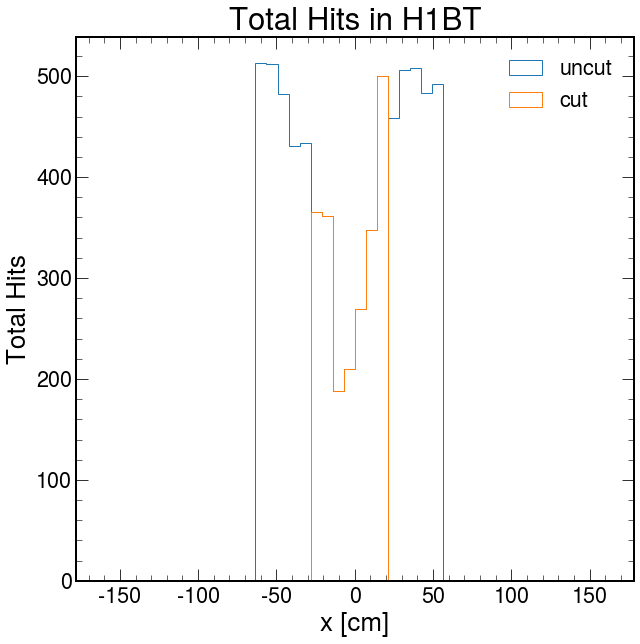

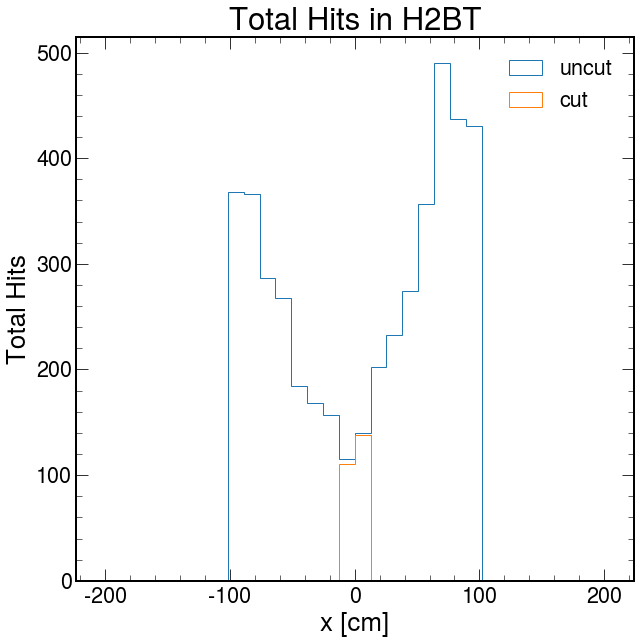

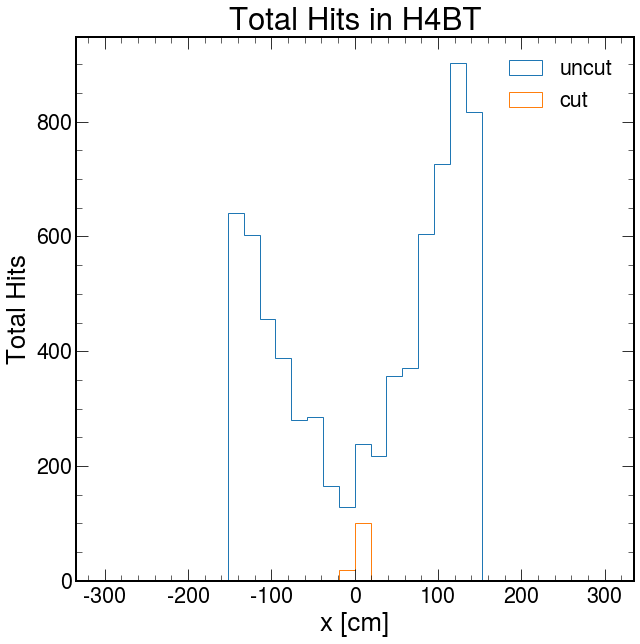

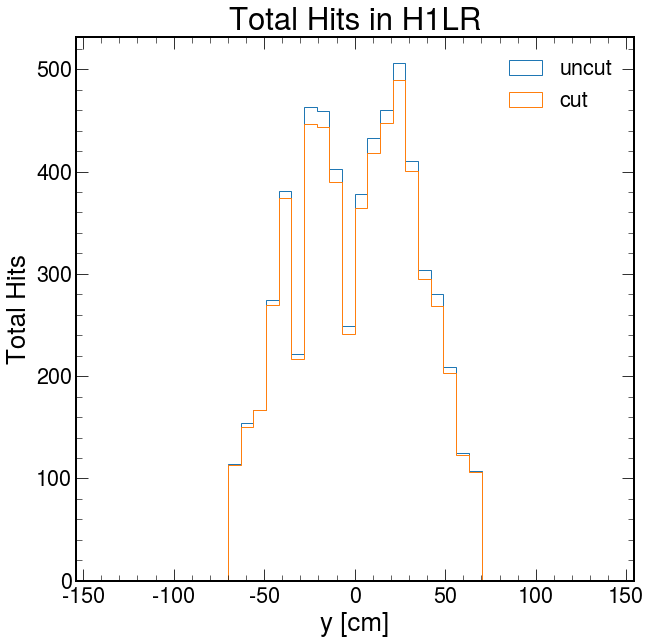

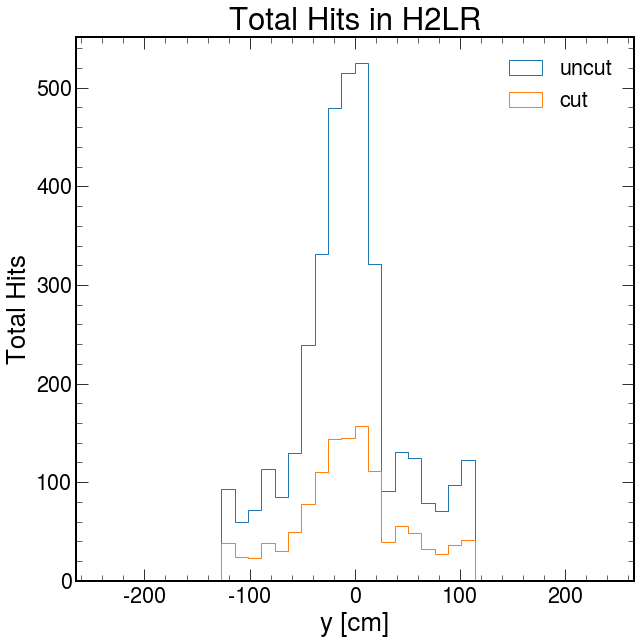

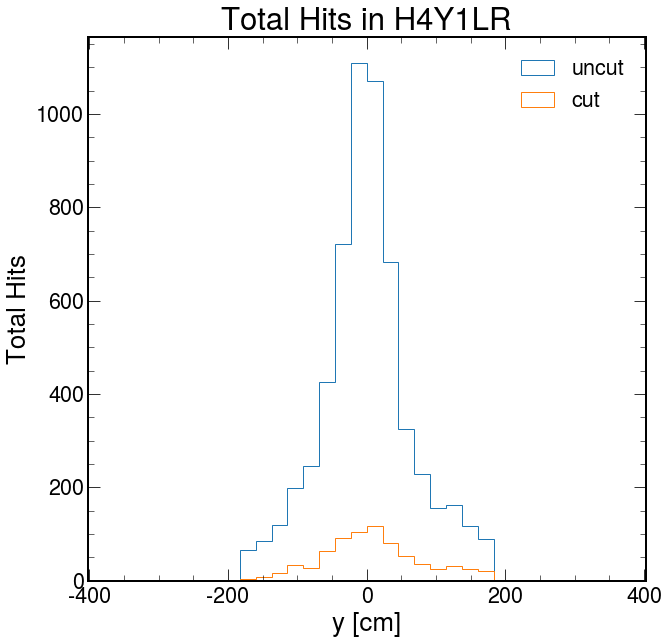

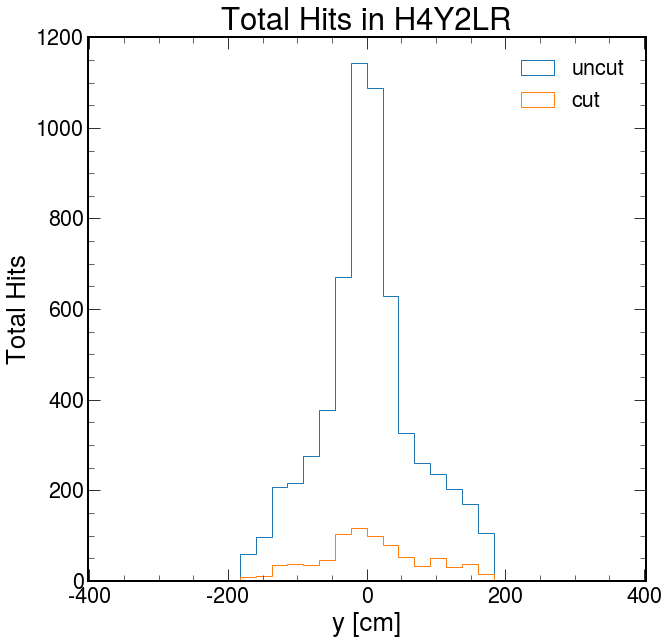

In [182]:
plotBG(a)

# Get signal data

In [184]:
# Thank you Cristina!
def getDataSim(fname="", procName="Truth"):
    dq_dict = uproot.open(fname)["Truth"]
    dq_events = ak.zip({"Hits":ak.zip({
                                      "detID":   dq_dict["hit_detID"].array(),
                                      "edep":    dq_dict["hit_edep"].array(),
                                      "elmID":   dq_dict["hit_elmID"].array(),
                                      "truthx":  dq_dict["hit_truthx"].array(),
                                      "truthy":  dq_dict["hit_truthy"].array(),
                                      "truthz":  dq_dict["hit_truthz"].array(),
                                      })
                        }, depth_limit=1)
    
    return dq_events

In [224]:
def layer4Sim(root, layer=[1], cut1=(-10,10), cut2=(-10,10), cut4=(-10,10)):
    '''
    root = background data ROOT file
    layer = layer(s) on which to cut 
        -> [1], [2], [4]
        -> [1, 2], [1, 4], [2, 4]
        -> [1, 2, 4]
    cut_ = x-positions between which to cut at each respective station
    '''
    # get L/R hodo data - needed for all cases
    # mask for these detectors
    h1lr = H1LR(root,data="signal")
    h2lr = H2LR(root,data="signal")
    h4y1lr = H4Y1LR(root,data="signal")
    h4y2lr = H4Y2LR(root,data="signal")
    # get hits in these detectors
    h1lr_hits = root[h1lr]
    h2lr_hits = root[h2lr]
    h4y1lr_hits = root[h4y1lr]
    h4y2lr_hits = root[h4y2lr]
    
    # now determine which cut(s) we are performing
    
    # we are only cutting on one layer
    if (len(layer)==1):
        # perform cut on station 1 ONLY
        if (layer[0]==1):
            h1_mask = H1BT(root,data="signal")
            h1_hits = root[h1_mask]
            x1_mask = (h1_hits.truthx >= cut1[0]) & (h1_hits.truthx <= cut1[1])   # only contains hits in region of cut
            x1_index = np.where(ak.any(x1_mask,axis=1))   # indices of all events meeting st1 criteria
            n1 = len(ak.flatten(x1_index))   # number of valid events after cut on st1
            
            # get data from station 2 (only events meeting st1 criteria)
            h2_mask = H2BT(root,data="signal")
            h2_hits = root[h2_mask]
            n2 = len(h2_hits[x1_index])  # should be equal to n1, n4
            
            # get data from station 4 (only events meeting st1 criteria)
            h4_mask = H4BT(root,data="signal")
            h4_hits = root[h4_mask]
            n4 = len(h4_hits[x1_index])  # should be equl to n1, n2
            
            # debug
            assert(n1==n2==n4)
            
            # return array of arrays containing [all hits, hits after cut(s), nevents]
            return [[h1_hits.truthx,     h1_hits[x1_mask].truthx,      n1], # H1BT
                    [h2_hits.truthx,     h2_hits[x1_index].truthx,     n2], # H2BT
                    [h4_hits.truthx,     h4_hits[x1_index].truthx,     n4], # H4BT
                    [h1lr_hits.truthy,   h1lr_hits[x1_index].truthy,   n1], # H1LR
                    [h2lr_hits.truthy,   h2lr_hits[x1_index].truthy,   n2], # H2LR
                    [h4y1lr_hits.truthy, h4y1lr_hits[x1_index].truthy, n4], # H4Y1LR
                    [h4y2lr_hits.truthy, h4y2lr_hits[x1_index].truthy, n4]] # H4Y2LR
        
        # perform cut on station 2 ONLY
        if (layer[0]==2):
            h1_mask = H1BT(root,data="signal")
            h1_hits = root[h1_mask]   # we're done with this layer, return all hits here
            n1 = len(h1_hits)   # n1 == 677 - we have no cut here, so no events rejected
            
            # get data from station 2
            h2_mask = H2BT(root,data="signal")
            h2_hits = root[h2_mask]
            x2_mask = (h2_hits.truthx >= cut2[0]) & (h2_hits.truthx <= cut2[1])  # only contains hits in region of cut
            x2_index = np.where(ak.any(x2_mask,axis=1))   # indices of all events meeting st2 criteria
            n2 = len(ak.flatten(x2_index))   # number of valid events after cut on st2
            
            # get data from station 4
            h4_mask = H4BT(root,data="signal")
            h4_hits = root[h4_mask]
            n4 = len(h4_hits[x2_index])  # should be equal to n2
            
            #debug
            assert(n2==n4)
            
            return [[h1_hits.truthx,     h1_hits.truthx,               n1], # H1BT
                    [h2_hits.truthx,     h2_hits[x2_mask].truthx,      n2], # H2BT
                    [h4_hits.truthx,     h4_hits[x2_index].truthx,     n4], # H4BT
                    [h1lr_hits.truthy,   h1lr_hits.truthy,             n1], # H1LR
                    [h2lr_hits.truthy,   h2lr_hits[x2_index].truthy,   n2], # H2LR
                    [h4y1lr_hits.truthy, h4y1lr_hits[x2_index].truthy, n4], # H4Y1LR
                    [h4y2lr_hits.truthy, h4y2lr_hits[x2_index].truthy, n4]] # H4Y2LR
        
        # perform cut on station 4 ONLY
        if (layer[0]==4):
            h1_mask = H1BT(root,data="signal")
            h1_hits = root[h1_mask]   # we're done with this layer, return all hits here
            n1 = len(h1_hits)   # n1 == 677 - we have no cut here, so no events rejected
            
            h2_mask = H2BT(root,data="signal")
            h2_hits = root[h2_mask]
            n2 = len(h2_hits)  # n1==n2==677 - again, no cuts here so all events kept
            
            # station 4 data - make cut
            h4_mask = H4BT(root,data="signal")
            h4_hits = root[h4_mask]
            x4_mask = (h4_hits.truthx >= cut4[0]) & (h4_hits.truthx <= cut4[1])  # only contains hits in the xrange
            x4_index = np.where(ak.any(x4_mask,axis=1))  # valid indices after st4 cut
            n4 = len(ak.flatten(x4_index))
            
            # debug 
            assert(n1==n2)
            
            return [[h1_hits.truthx,     h1_hits.truthx,               n1], # H1BT
                    [h2_hits.truthx,     h2_hits.truthx,               n2], # H2BT
                    [h4_hits.truthx,     h4_hits[x4_mask].truthx,      n4], # H4BT
                    [h1lr_hits.truthy,   h1lr_hits.truthy,             n1], # H1LR
                    [h2lr_hits.truthy,   h2lr_hits.truthy,             n2], # H2LR
                    [h4y1lr_hits.truthy, h4y1lr_hits[x4_index].truthy, n4], # H4Y1LR
                    [h4y2lr_hits.truthy, h4y2lr_hits[x4_index].truthy, n4]] # H4Y2LR
            
    
    # we are cutting on 2 layers [1,2], [2,4], [1,4]
    # when performing sequential cuts, we need to plot the data only in the desired cut range
    # and only for events which have passed all prior selection criteria ******important******
    elif (len(layer)==2):
        if ((layer==[1,2]) or (layer==[2,1])):
            h1_mask = H1BT(root,data="signal")
            h1_hits = root[h1_mask]
            x1_mask = (h1_hits.truthx >= cut1[0]) & (h1_hits.truthx <= cut1[1])
            x1_index = np.where(ak.any(x1_mask,axis=1))
            n1 = len(ak.flatten(x1_index))
            
            h2_mask = H2BT(root,data="signal")
            h2_hits = root[h2_mask]
            # now get the hits from events only meeting station 1 criteria
            h2_hits_after = h2_hits[x1_index]
            # now get the hits from within given x-range from those events
            h2_mask_after = (h2_hits_after.truthx >= cut2[0]) & (h2_hits_after.truthx <= cut2[1])
            x2_mask = (h2_hits.truthx >= cut2[0]) & (h2_hits.truthx <= cut2[1])
            x2_index = np.where(ak.any(x2_mask,axis=1))
            # get indices of events meeting st1 and st2 criteria
            x1x2_index = np.intersect1d(x1_index, x2_index)
            #n2 = len(h2_hits_after)
            n2 = len(x1x2_index)
            
            # no cut on h4
            h4_mask = H4BT(root,data="signal")
            h4_hits = root[h4_mask]
            n4 = len(h4_hits[x1x2_index])   # number of valid events after final cut (st2)
            
            return [[h1_hits.truthx,     h1_hits[x1_mask].truthx,             n1], # H1BT
                    [h2_hits.truthx,     h2_hits_after[h2_mask_after].truthx, n2], # H2BT
                    [h4_hits.truthx,     h4_hits[x1x2_index].truthx,          n4], # H4BT
                    [h1lr_hits.truthy,   h1lr_hits[x1_index].truthy,          n1], # H1LR
                    [h2lr_hits.truthy,   h2lr_hits[x1x2_index].truthy,        n2], # H2LR
                    [h4y1lr_hits.truthy, h4y1lr_hits[x1x2_index].truthy,      n4], # H4Y1LR
                    [h4y2lr_hits.truthy, h4y2lr_hits[x1x2_index].truthy,      n4]] # H4Y2LR
    
        if ((layer==[2,4]) or (layer==[4,2])):
            h1_mask = H1BT(root,data="signal")
            h1_hits = root[h1_mask]
            n1 = len(h1_hits)   # n1 == 677 - no cuts applied on st1, so all events kept
            
            h2_mask = H2BT(root,data="signal")
            h2_hits = root[h2_mask]
            x2_mask = (h2_hits.truthx >= cut2[0]) & (h2_hits.truthx <= cut2[1])
            x2_index = np.where(ak.any(x2_mask,axis=1))
            n2 = len(ak.flatten(x2_index))
            
            h4_mask = H4BT(root,data="signal")
            h4_hits = root[h4_mask]
            h4_hits_after = h4_hits[x2_index]
            h4_mask_after = (h4_hits_after.truthx >= cut4[0]) & (h4_hits_after.truthx <= cut4[1])
            x4_mask = (h4_hits.truthx >= cut4[0]) & (h4_hits.truthx <= cut4[1])
            x4_index = np.where(ak.any(x4_mask,axis=1))
            # get indices of events meeting st2 and st4 criteria
            x2x4_index = np.intersect1d(x2_index, x4_index)
            #n4 = len(h4_hits_after)
            n4 = len(x2x4_index)
            
            return [[h1_hits.truthx,     h1_hits.truthx,                      n1], # H1BT
                    [h2_hits.truthx,     h2_hits[x2_mask].truthx,             n2], # H2BT
                    [h4_hits.truthx,     h4_hits_after[h4_mask_after].truthx, n4], # H4BT
                    [h1lr_hits.truthy,   h1lr_hits.truthy,                    n1], # H1LR
                    [h2lr_hits.truthy,   h2lr_hits[x2_index].truthy,          n2], # H2LR
                    [h4y1lr_hits.truthy, h4y1lr_hits[x2x4_index].truthy,      n4], # H4Y1LR
                    [h4y2lr_hits.truthy, h4y2lr_hits[x2x4_index].truthy,      n4]] # H4Y2LR
            
        if ((layer==[1,4]) or (layer==[4,1])):
            h1_mask = H1BT(root,data="signal")
            h1_hits = root[h1_mask]
            x1_mask = (h1_hits.truthx >= cut1[0]) & (h1_hits.truthx <= cut1[1])
            x1_index = np.where(ak.any(x1_mask,axis=1))
            n1 = len(ak.flatten(x1_index))
            
            # NO cut applied here 
            h2_mask = H2BT(root,data="signal")
            h2_hits = root[h1_mask]
            n2 = len(h2_hits[x1_index])  # n1 should equal n2
            
            # debug 
            assert(n1==n2)
            
            h4_mask = H4BT(root,data="signal")
            h4_hits = root[h4_mask]
            h4_hits_after = h4_hits[x1_index]
            h4_mask_after = (h4_hits_after.truthx >= cut4[0]) & (h4_hits_after.truthx <= cut4[1])
            x4_mask = (h4_hits.truthx >= cut4[0]) & (h4_hits.truthx <= cut4[1])
            x4_index = np.where(ak.any(x4_mask,axis=1))
            x1x4_index = np.intersect1d(x1_index, x4_index)
            #n4 = len(h4_hits_after)
            n4 = len(x1x4_index)
            
            return [[h1_hits.truthx,     h1_hits[x1_mask].truthx,             n1], # H1BT
                    [h2_hits.truthx,     h2_hits[x1_index].truthx,            n2], # H2BT
                    [h4_hits.truthx,     h4_hits_after[h4_mask_after].truthx, n4], # H4BT
                    [h1lr_hits.truthy,   h1lr_hits[x1_index].truthy,          n1], # H1LR
                    [h2lr_hits.truthy,   h2lr_hits[x1_index].truthy,          n2], # H2LR
                    [h4y1lr_hits.truthy, h4y1lr_hits[x1x4_index].truthy,      n4], # H4Y1LR
                    [h4y2lr_hits.truthy, h4y2lr_hits[x1x4_index].truthy,      n4]] # H4Y2LR
            
    # finally, three sequential cuts (layer==[1,2,4])
    elif (len(layer)==3):
        # perform the cut on station 1
        h1_mask = H1BT(root,data="signal")
        h1_hits = root[h1_mask]
        x1_mask = (h1_hits.truthx >= cut1[0]) & (h1_hits.truthx <= cut1[1])
        x1_index = np.where(ak.any(x1_mask,axis=1))
        n1 = len(ak.flatten(x1_index))
        
        # perform the cut on station 2
        h2_mask = H2BT(root,data="signal")
        h2_hits = root[h2_mask]
        h2_hits_after = h2_hits[x1_index]        
        h2_mask_after = (h2_hits_after.truthx >= cut2[0]) & (h2_hits_after.truthx <= cut2[1])
        x2_mask = (h2_hits.truthx >= cut2[0]) & (h2_hits.truthx <= cut2[1])
        x2_index = np.where(ak.any(x2_mask,axis=1))
        x1x2_index = np.intersect1d(x1_index, x2_index)
        #n2 = len(h2_hits_after)
        n2 = len(x1x2_index)
        
        # perform final cut on station 4
        h4_mask = H4BT(root,data="signal")
        h4_hits = root[h4_mask]
        h4_hits_after = h4_hits[x1x2_index]
        h4_mask_after = (h4_hits_after.truthx >= cut4[0]) & (h4_hits_after.truthx <= cut4[1])
        x4_mask = (h4_hits.truthx >= cut4[0]) & (h4_hits.truthx <= cut4[1])
        x4_index = np.where(ak.any(x4_mask,axis=1))
        x1x2x4_index = np.intersect1d(x1x2_index,x4_index)
        #n4 = len(h4_hits_after)
        n4 = len(x1x2x4_index)
        
        assert(n4 == len(x1x2x4_index))
        
        return [[h1_hits.truthx,     h1_hits[x1_mask].truthx,             n1], # H1BT
                [h2_hits.truthx,     h2_hits_after[h2_mask_after].truthx, n2], # H2BT
                [h4_hits.truthx,     h4_hits_after[h4_mask_after].truthx, n4], # H4BT
                [h1lr_hits.truthy,   h1lr_hits[x1_index].truthy,          n1], # H1LR
                [h2lr_hits.truthy,   h2lr_hits[x1x2_index].truthy,        n2], # H2LR
                [h4y1lr_hits.truthy, h4y1lr_hits[x1x2x4_index].truthy,    n4], # H4Y1LR
                [h4y2lr_hits.truthy, h4y2lr_hits[x1x2x4_index].truthy,    n4]] # H4Y2LR
        
    else:
        print("not a valid cut selection")


In [225]:
def plot_Sim(hists, weighted=False):
    '''Use to plot only simulation data w/ cuts'''
    bins_range = [(46, (-162.008,162.008), "H1BT"),
                  (32, (-203.38,203.38), "H2BT"),
                  (32, (-304.518,304.518), "H4BT"),
                  (40, (-140.117,140.117), "H1LR"),
                  (38, (-241.285,241.285), "H2LR"),
                  (32, (-365.797,365.797), "H4Y1LR"),
                  (32, (-365.797,365.797), "H4Y2LR")]

    for i in range(len(hists)):
        # weighting
        if (weighted==True):
            ws_uncut = np.ones_like(ak.to_numpy(ak.flatten(hists[i][0])))/10000   # hard code (10,000 sim evts)
            ws_cut = np.ones_like(ak.to_numpy(ak.flatten(hists[i][1])))/hists[i][2]
            if (i==2) or (i==5) or (i==6):
                ws_uncut /= 2
                ws_cut /= 2
        plt.clf()
        if (weighted==True):
            plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="uncut",weights=ws_uncut)
            plt.hist(ak.flatten(hists[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="cut",weights=ws_cut)
            plt.ylabel("Hits/Event")
            plt.title("Hits/Event in {}".format(bins_range[i][2]))
        else:
            plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="uncut")
            plt.hist(ak.flatten(hists[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="cut")
            plt.ylabel("Total Hits")
            plt.title("Total Hits in {}".format(bins_range[i][2]))
        if (i<3):
            plt.xlabel("x [cm]")
        else:
            plt.xlabel("y [cm]")
        plt.legend()
        plt.show()

In [226]:
b = layer4Sim(Truth054,layer=[1,2,4])

In [227]:
b

[[<Array [[-1.79, -3.86], ... [-10.1, -1.43]] type='10000 * var * float64'>,
  <Array [[-1.79, -3.86], ... 6.54], [-1.43]] type='10000 * var * float64'>,
  7690],
 [<Array [[15.2], [], [18.4, ... [20.7], [-19.7]] type='10000 * var * float64'>,
  <Array [[], [], [], [], ... [5.25], [], []] type='7690 * var * float64'>,
  1862],
 [<Array [[-43.9], [33.5], ... [6.95], [-25.2]] type='10000 * var * float64'>,
  <Array [[], [], [], [7.26, ... [1.65], [], []] type='1862 * var * float64'>,
  398],
 [<Array [[0.579, 0.579, ... 1.38, -0.65]] type='10000 * var * float64'>,
  <Array [[0.579, 0.579, ... 1.38, -0.65]] type='7690 * var * float64'>,
  7690],
 [<Array [[-12.8, 3.55], ... -7.42], [-4.36]] type='10000 * var * float64'>,
  <Array [[-12.6, 30.7, 30.7, ... -41.1, -0.655]] type='1862 * var * float64'>,
  1862],
 [<Array [[6.49], [3.13], ... 30.5], [-8.03]] type='10000 * var * float64'>,
  <Array [[-6.81, -6.89], ... [-6.82, -6.88]] type='398 * var * float64'>,
  398],
 [<Array [[6.76], [3.05

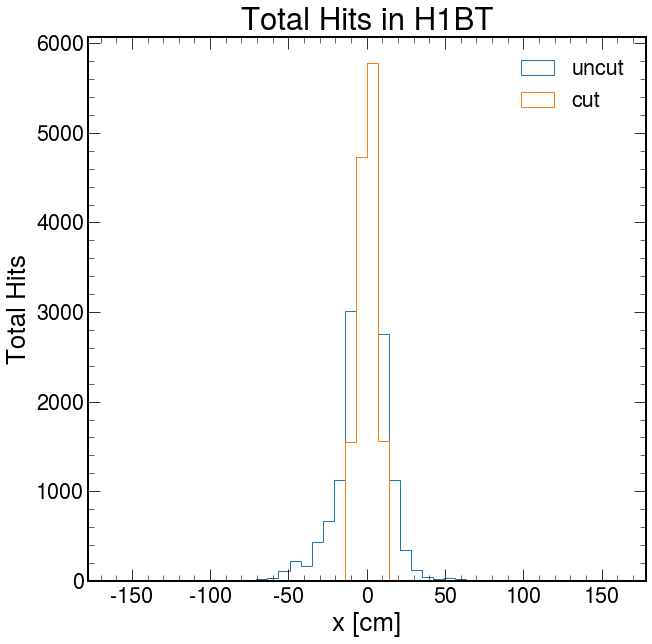

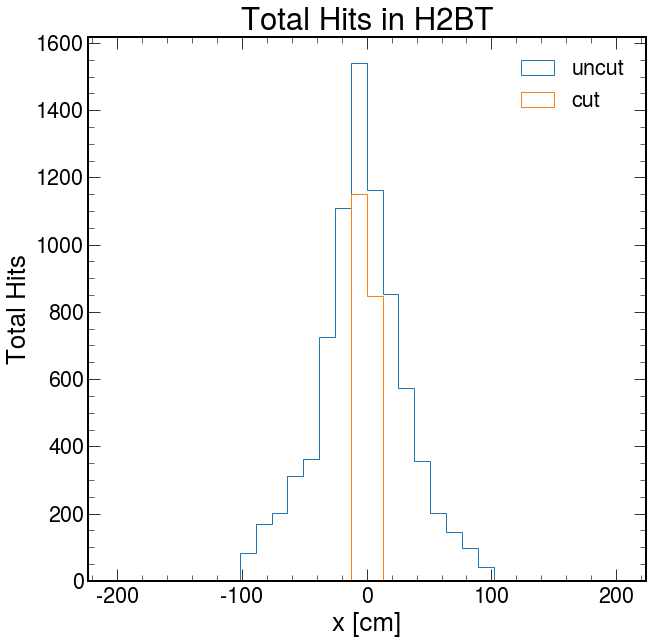

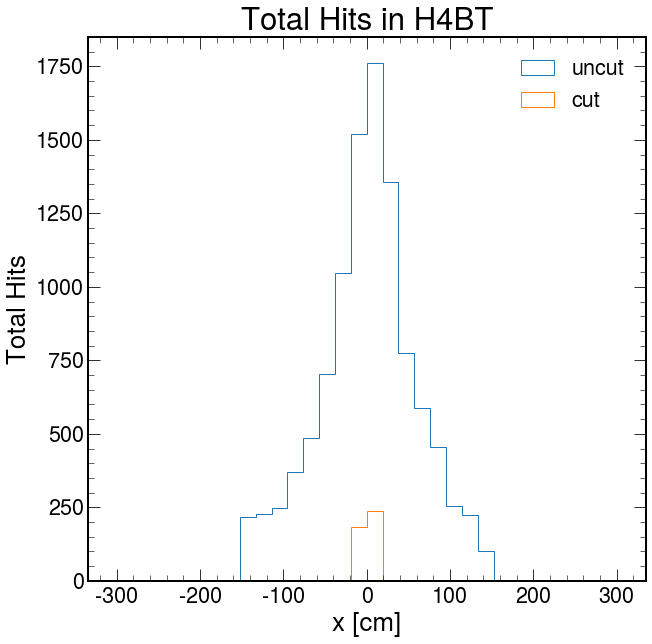

/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


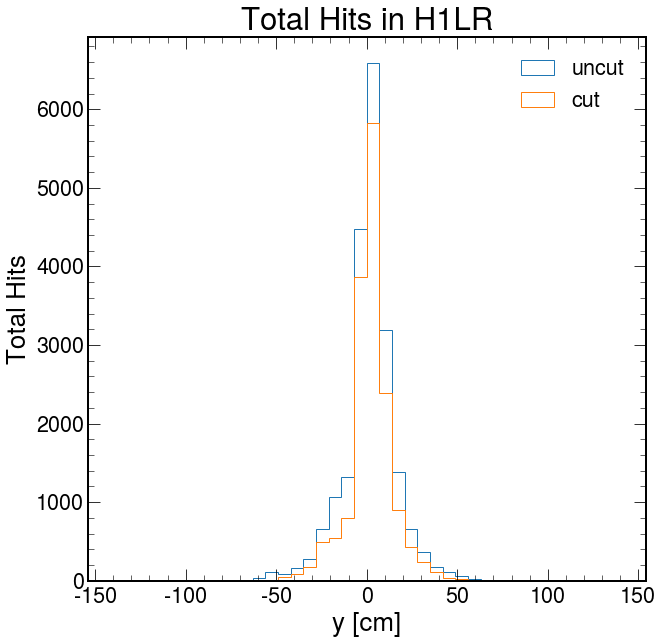

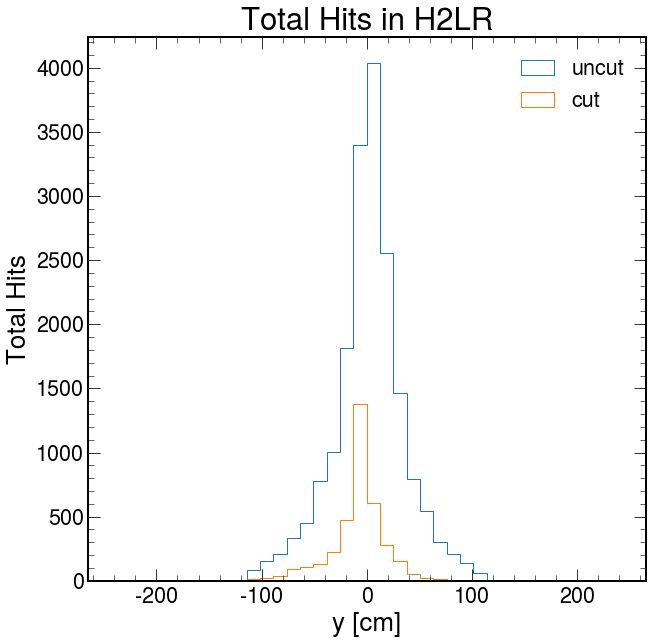

/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


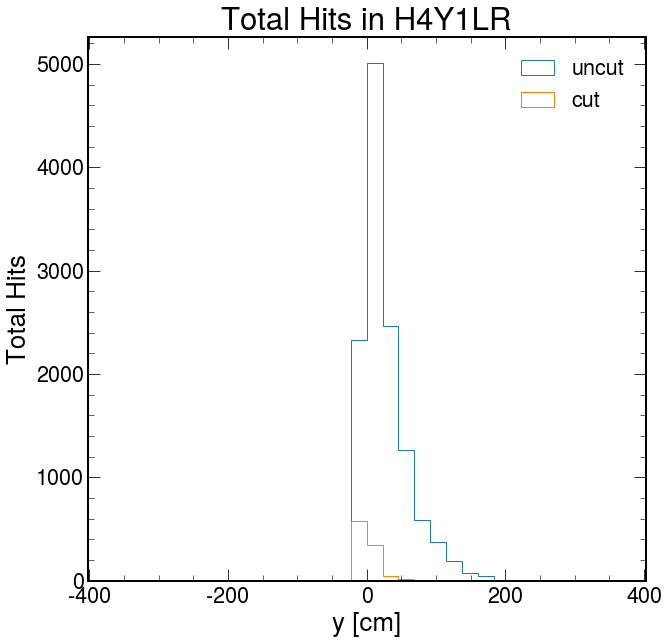

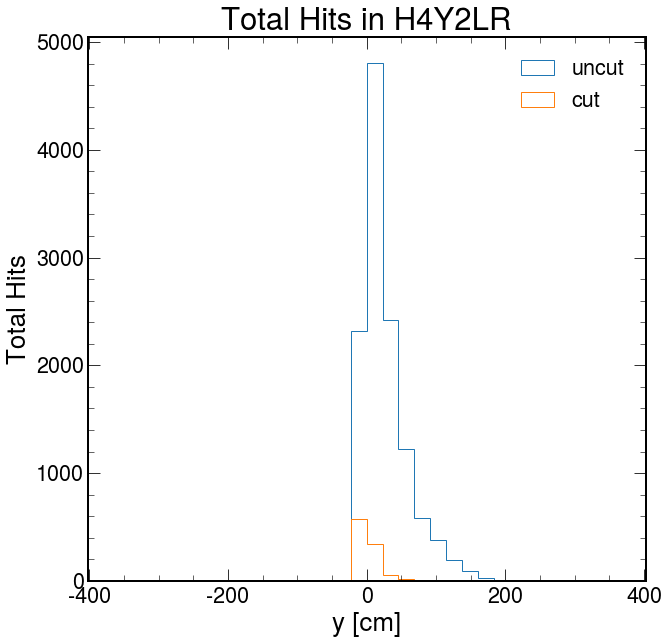

In [228]:
plot_Sim(b)

getting the actual ROOT file data from the names

In [72]:
# ROOT files
Truth003 = getDataSim(Brem003)["Hits"]
Truth047 = getDataSim(Brem047)["Hits"]
Truth001 = getDataSim(Eta001)["Hits"]
Truth054 = getDataSim(Eta054)["Hits"]

# Comparing signal to background after cuts

In [229]:
def plot_overlay(bg, sim, name, sim2=False, name2=False, weighted=False):
    '''
    bg, sim are the respective histogram lists generated by layer4_ function
    '''
    # get process names and masses
    mass = name.split("_")[3][0:4] + " MeV"
    proc = name.split("_")[2]
    if (sim2 != False):
        mass2 = name2.split("_")[3][0:4] + " MeV"
        proc2 = name2.split("_")[2]
        
    bins_range = [(46, (-162.008,162.008), "H1BT"),
                  (32, (-203.38,203.38), "H2BT"),
                  (32, (-304.518,304.518), "H4BT"),
                  (40, (-140.117,140.117), "H1LR"),
                  (38, (-241.285,241.285), "H2LR"),
                  (32, (-365.797,365.797), "H4Y1LR"),
                  (32, (-365.797,365.797), "H4Y2LR")]
    
    # the histogram lists are both in the form:
    # [uncut, cut, nevents] (nevents = number of valid events after st4 cut)
    for i in range(7):
        # weighting
        if (weighted==True):
            ws_bg = np.ones_like(ak.to_numpy(ak.flatten(bg[i][1])))/bg[i][2]
            ws_sim = np.ones_like(ak.to_numpy(ak.flatten(sim[i][1])))/sim[i][2]
            if (i==2) or (i==5) or (i==6):
                ws_bg /= 2
                ws_sim /= 2
            if (sim2 != False):
                ws_sim2 = np.ones_like(ak.to_numpy(ak.flatten(sim2[i][1])))/sim2[i][2]
                if (i==2) or (i==5) or (i==6):
                    ws_sim2 /= 2
        
        plt.clf()
        if (weighted==True):
            plt.hist(ak.flatten(bg[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="data",weights=ws_bg)
            plt.hist(ak.flatten(sim[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass,weights=ws_sim)
            plt.ylabel("Hits/Event")
            plt.title("Hits/Event in {} ({})".format(bins_range[i][2],proc))
            if (sim2 != False):
                plt.hist(ak.flatten(sim2[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass2,weights=ws_sim2)    
            
        else:
            plt.hist(ak.flatten(bg[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="data")
            plt.hist(ak.flatten(sim[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass)
            plt.ylabel("Total Hits")
            plt.title("Total Hits in {} ({})".format(bins_range[i][2],proc))
            if (sim2 != False):
                plt.hist(ak.flatten(sim2[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass2,weights=ws_sim2)
        if (i<3):
            plt.xlabel("x [cm]")
        else:
            plt.xlabel("y [cm]")
        plt.legend()
        plt.savefig("{}_{}".format(bins_range[i][2],proc))
        plt.show()

**Plot**

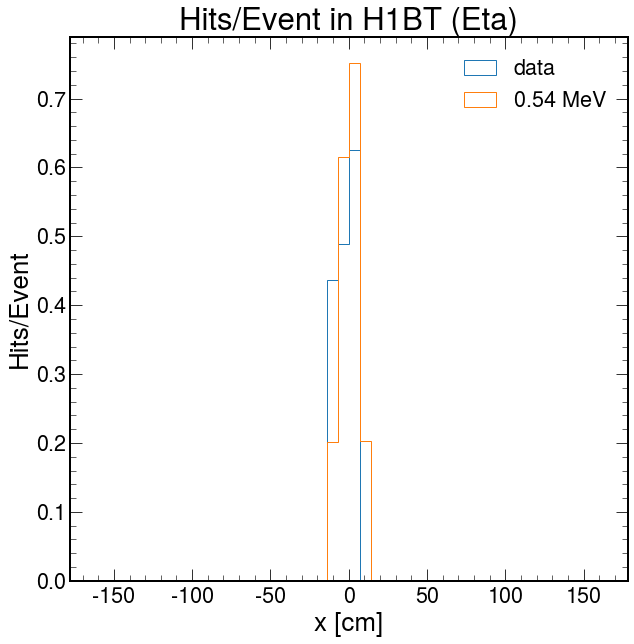

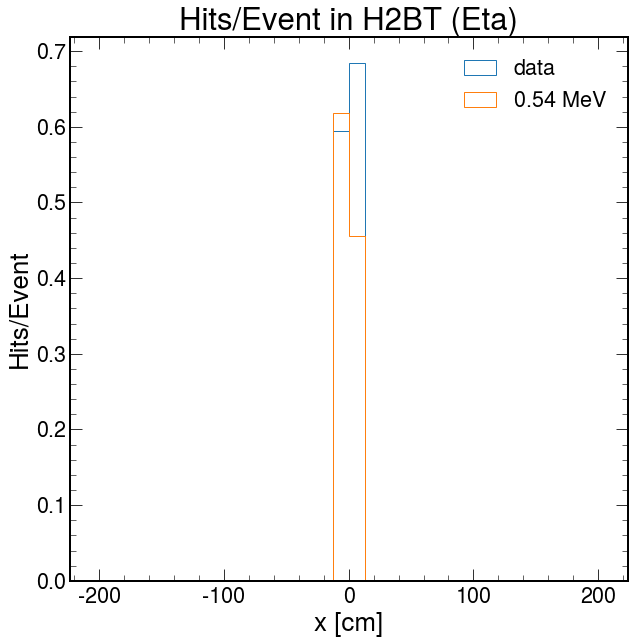

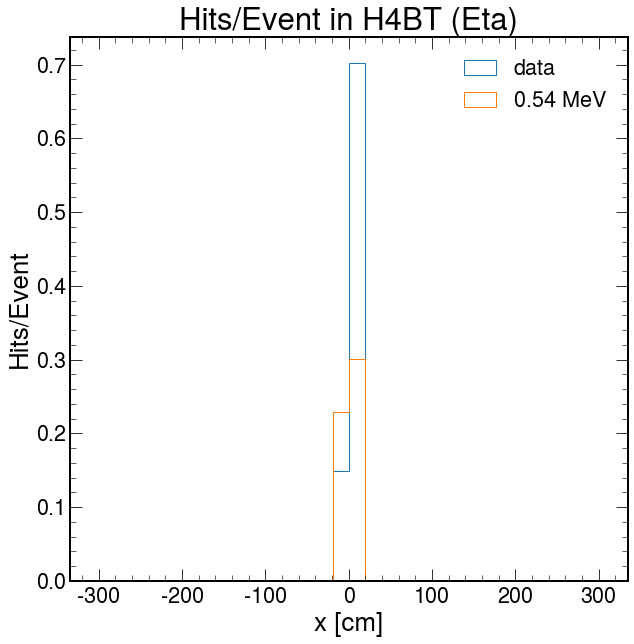

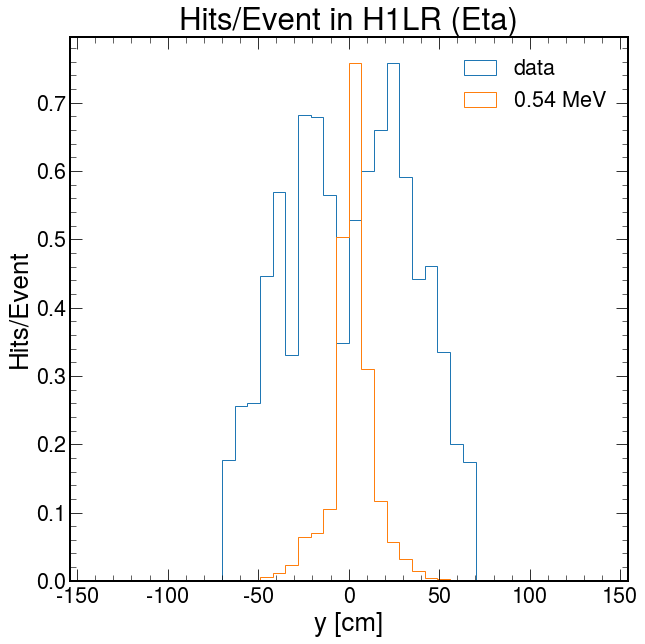

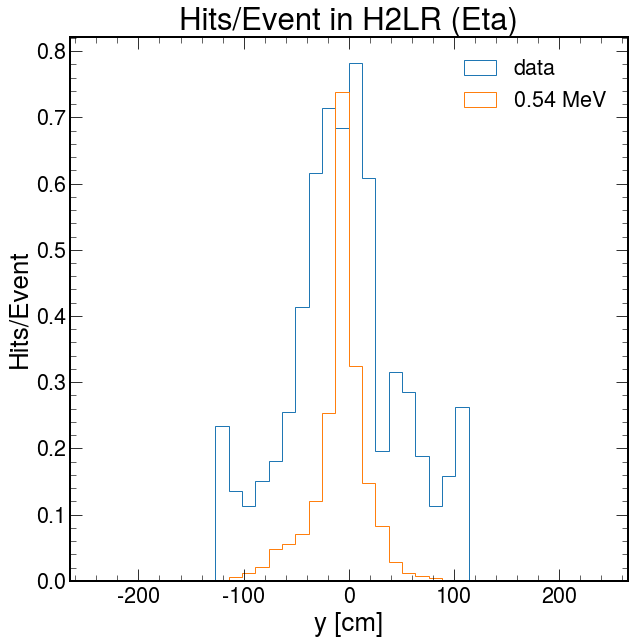

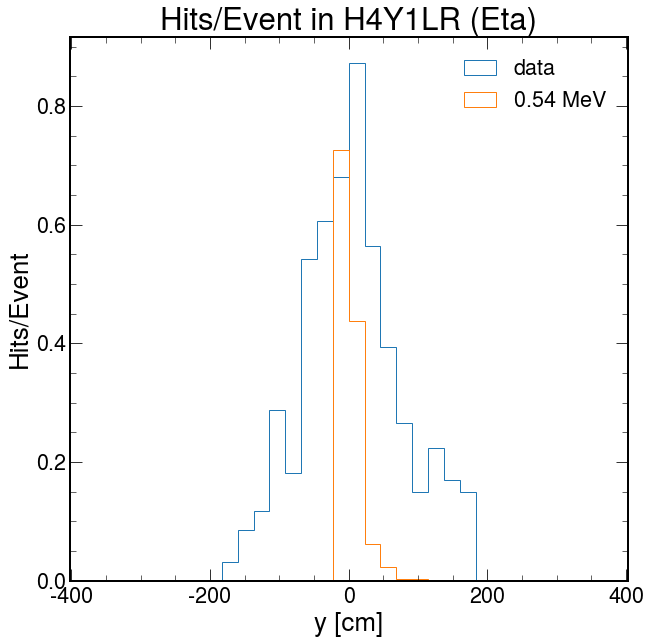

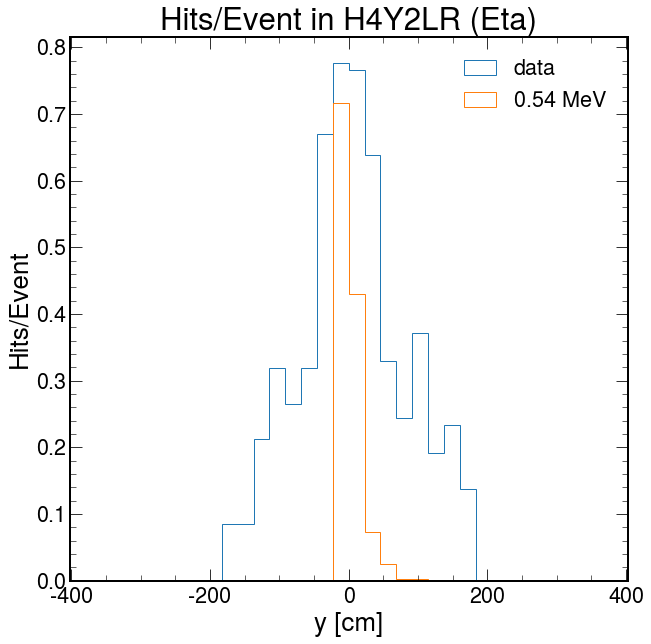

In [244]:
bg = layer4BG(root,layer=[1,2,4])
sim = layer4Sim(Truth054,layer=[1,2,4])
plot_overlay(bg,sim,Eta054,weighted=True)